In [1]:
import os
import subprocess
import random
import warnings
import numpy as np
from scipy.linalg import sqrtm
from scipy.stats import unitary_group
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from tqdm.notebook import tqdm
import itertools

import torch
from qucumber.nn_states import DensityMatrix
from qucumber.nn_states import ComplexWaveFunction
from qucumber.callbacks import MetricEvaluator
import qucumber.utils.unitaries as unitaries
import qucumber.utils.training_statistics as ts
import qucumber.utils.cplx as cplx
import qucumber.utils.data as data
from qucumber.observables import ObservableBase, to_pm1
from qucumber.observables.pauli import flip_spin
import qucumber

from qulacs.gate import Pauli

%load_ext autoreload
%autoreload 2
import target_circuit
import statistics

In [2]:
with open('./params_setting.yaml', 'r') as yml:
    params = yaml.safe_load(yml)
    
# quantum circuit parameter
circuit_name = params["circuit_info"]["circuit_name"]
n_qubit = params["circuit_info"]["n_qubit"]
state_class = params["circuit_info"]["state_class"]
error_model = params["circuit_info"]["error_model"]
error_rate = params["circuit_info"]["error_rate"]
each_n_shot = params["circuit_info"]["each_n_shot"]

# RBM architecture parameter
num_visible = params["architecture_info"]["n_visible_unit"]
num_hidden = params["architecture_info"]["n_hidden_unit"] 
num_aux = params["architecture_info"]["n_aux_unit"]

# train parameter
lr = params["train_info"]["lr"]
pbs = params["train_info"]["positive_batch_size"]
nbs = params["train_info"]["negative_batch_size"]
n_gibbs_step = params["train_info"]["n_gibbs_step"]
period = 1
epoch = params["train_info"]["n_epoch"]
lr_drop_epoch = params["train_info"]["lr_drop_epoch"]
lr_drop_factor = params["train_info"]["lr_drop_factor"]
use_gpu = params["train_info"]["use_gpu"]
seed = params["train_info"]["seed"]

# sampling parameter
n_sampling = params["sampling_info"]["n_sample"]
n_copy = params["sampling_info"]["n_copy"]

# data path info
environment = "local"
if environment == "local":
    train_data_path = f"./{circuit_name}/data/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"
    target_state_path = f"./{circuit_name}/target_state/{state_class}/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/"
    model_path = f"./{circuit_name}/model/{state_class}/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"
    train_log_path = f"./{circuit_name}/train_log/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"
if environment == "colab":
    from google.colab import drive
    drive.mount("/content/drive/")
    drive_path = "/content/drive/MyDrive/NQS4VD/GHZ"
    train_data_path = drive_path + f"/{circuit_name}/data/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"
    target_state_path = drive_path + f"/{circuit_name}/target_state/{state_class}/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/"
    model_path = drive_path + f"/{circuit_name}/model/{state_class}/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"
    train_log_path = drive_path + f"/{circuit_name}/train_log/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"


def seed_settings(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    qucumber.set_random_seed(seed, cpu=True, gpu=False)

seed_settings(seed=seed)

## depolarizing error

In [4]:
nn_state_dep = DensityMatrix.autoload(f"./{circuit_name}/model/{state_class}/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/epoch500_model.pt", gpu = use_gpu)
obs_mat = Pauli([0, 1, 2, 3], [3, 3, 3, 3]).get_matrix()
n_copy_list = np.arange(1, 11)
bias_dep_list = []
ideal_state = target_circuit.GHZ(n_qubit, state_class, "ideal", error_rate)

for n_copy in tqdm(n_copy_list):
    bias_dep = statistics.bias(nn_state_dep, ideal_state, n_copy, obs_mat)
    bias_dep_list.append(bias_dep)

  0%|          | 0/10 [00:00<?, ?it/s]

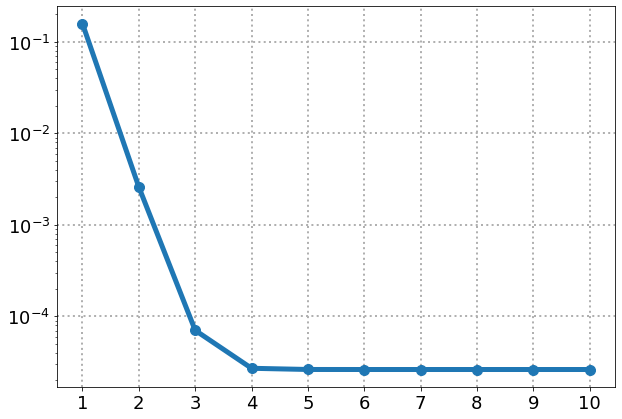

In [48]:
plt.figure(figsize=(10, 7))
plt.plot(n_copy_list, bias_dep_list, marker="o", markersize=10, linewidth=5)
#plt.title(f'varying number of quantum state copies (error rate:{error_rate*100}%)', fontsize=18)
#plt.xlabel('number of quantum state copies', fontsize=18)
#plt.ylabel('bias of expectation value $<O>$', fontsize=18)
plt.xticks(np.arange(1, 11))
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.grid(linestyle='dotted', linewidth=2)
plt.savefig(f"./{circuit_name}/train_log/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/plot_bias.pdf", bbox_inches='tight')

In [37]:
var_dep_list = np.load("./variance_dep_data.npy")
rmse_dep_list = np.load("./rmse_dep_data.npy")
noisy_state = target_circuit.GHZ(n_qubit, state_class, "depolarizing", error_rate)
obs_mat = Pauli([0, 1, 2, 3], [3, 3, 3, 3]).get_matrix()
noisy_ev = np.trace(obs_mat@noisy_state).real

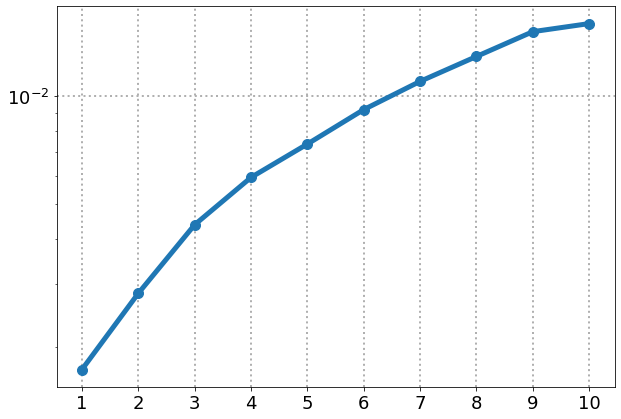

In [65]:
plt.figure(figsize=(10, 7))
plt.plot(n_copy_list, np.sqrt(var_dep_list), marker="o",  markersize=10, linewidth=5)
#plt.title(f'varying number of quantum state copies (error rate:{error_rate*100}%)', fontsize=18)
#plt.xlabel('number of quantum state copies', fontsize=18)
#plt.ylabel('standard error of expectation value $<O>$', fontsize=18)
plt.xticks(np.arange(1, 11))
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.grid(linestyle='dotted', linewidth=2)
plt.savefig(f"./{circuit_name}/train_log/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/plot_std_error.pdf", bbox_inches='tight')

/opt/conda/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/conda/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/conda/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


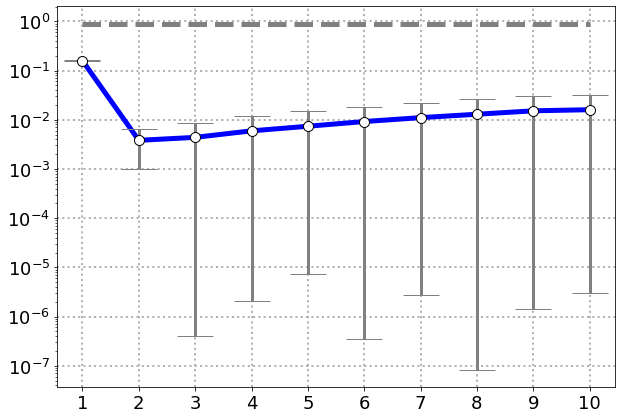

In [68]:
plt.figure(figsize=(10, 7))
plt.plot(n_copy_list, np.repeat(noisy_ev, 10), "--", linewidth=5, color = "gray")
plt.plot(n_copy_list, rmse_dep_list, marker="o", linewidth=5, color = "blue")
plt.errorbar(n_copy_list, rmse_dep_list, yerr = np.sqrt(var_dep_list), capsize=18, fmt='o', markersize=10, ecolor='gray', markeredgecolor = "black", color='w', elinewidth=3)
#plt.title(f'varying number of quantum state copies (error rate:{error_rate*100}%)', fontsize=18)
#plt.xlabel('number of quantum state copies', fontsize=18)
#plt.ylabel('RMSE of expectation value $<O>$', fontsize=18)
plt.xticks(np.arange(1, 11))
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.grid(linestyle='dotted', linewidth=2)
plt.savefig(f"./{circuit_name}/train_log/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/plot_rmse.pdf", bbox_inches='tight')